# Synthetic Discussions analysis

## Preprocessing

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


def get_toxicity_annotation(annot_str: str) -> int:
    try:
        annot_str = str(annot_str)
        number = annot_str.split("=")[1]
        return int(number)
    except Exception as e:
        return -1


def get_user_intent(prompt: str) -> str:
    prompt = prompt.lower()

    if prompt == "nan":
        return "Neutral"
    elif "troll" in prompt:
        return "Troll"
    elif "smoothly" in prompt:
        return "Helpful"
    else:
        return "Unknown"


def moderator_exists(df: pd.DataFrame) -> pd.Series:
    moderator_ids = set(df[df["user"] == "moderator"]["conv_id"])
    return df["conv_id"].apply(lambda x: x in moderator_ids)


df = pd.read_csv("../data/dataset.csv", encoding="utf8")

df = df.astype(str)
df.annotation = df.annotation.apply(get_toxicity_annotation).astype(int)
df.is_moderator = (df.is_moderator == "True").astype(bool)
df["intent"] = df.special_instructions.apply(get_user_intent).astype(str)
df.intent = np.where(df.is_moderator, "Moderator", df.intent).astype(str)
df["moderator_exists"] = moderator_exists(df)

df = df.loc[:, ["conv_id", "conv_variant", "user", "user_prompt", "is_moderator", "intent", "message", "annotation", "moderator_exists"]]
df = df[df.conv_variant != "test"]

df

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
0,f4180bed-c44e-4044-ab9d-82dc32bc4e5f,vanilla,TechGuru88,You are a human participating in an online cha...,False,Neutral,"In other words, he’s not brown enough for ya t...",3,True
1,f4180bed-c44e-4044-ab9d-82dc32bc4e5f,vanilla,QueenOfChaos,You are a human participating in an online cha...,False,Troll,"@TechGuru88, oh please, you're just mad beca...",3,True
2,f4180bed-c44e-4044-ab9d-82dc32bc4e5f,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,3,True
3,f4180bed-c44e-4044-ab9d-82dc32bc4e5f,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,4,True
4,f4180bed-c44e-4044-ab9d-82dc32bc4e5f,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,1,True
...,...,...,...,...,...,...,...,...,...
7008,365145db-8ed8-4f00-b6f1-78c2cf8d036a,no_mod,GoldenYears66,You are a human participating in an online cha...,False,Neutral,"@WiseOwl71, you're preaching to the choir her...",1,False
7009,365145db-8ed8-4f00-b6f1-78c2cf8d036a,no_mod,TechGuru88,You are a human participating in an online cha...,False,Neutral,"@WiseOwl71, @GoldenYears66, you're both right...",1,False
7010,365145db-8ed8-4f00-b6f1-78c2cf8d036a,no_mod,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@GoldenYears66, @WiseOwl71, you both make gre...",1,False
7011,365145db-8ed8-4f00-b6f1-78c2cf8d036a,no_mod,DarkShadow333,You are a human participating in an online cha...,False,Troll,"@WiseOwl71, @GoldenYears66, you're both so fu...",4,False


In [11]:
df.intent.unique()

array(['Neutral', 'Troll', 'Moderator', 'Helpful'], dtype=object)

In [12]:
df.loc[df.annotation == -1]

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
311,a762a589-6bd6-4c81-a829-7e102e32223a,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
327,a762a589-6bd6-4c81-a829-7e102e32223a,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
333,a762a589-6bd6-4c81-a829-7e102e32223a,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
341,a762a589-6bd6-4c81-a829-7e102e32223a,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
349,a762a589-6bd6-4c81-a829-7e102e32223a,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
1333,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
1347,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
1361,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
1375,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True
1389,e6bba036-c643-4284-8d18-b43d020c4aad,vanilla,moderator,You are a human participating in an online cha...,True,Moderator,,-1,True


In [13]:
df.loc[(df.annotation == -1) & (df.message.apply(lambda x: x.strip()) != "")]

,conv_id,conv_variant,user,user_prompt,is_moderator,intent,message,annotation,moderator_exists
6611,b810187f-1d75-4d79-a3d8-1e8caf4fc6fa,no_mod,doing_my_best24,You are a human participating in an online cha...,False,Helpful,"@QueenOfChaos, I think you're missing the poi...",-1,False
6852,01f0d12c-acf1-4a03-b809-6b6291cc9613,no_mod,WiseOwl71,You are a human participating in an online cha...,False,Helpful,"@doing_my_best24, you raise a valid point abo...",-1,False


## Analysis

In [14]:
sns.set(style="whitegrid")

### User intent impact on toxicity

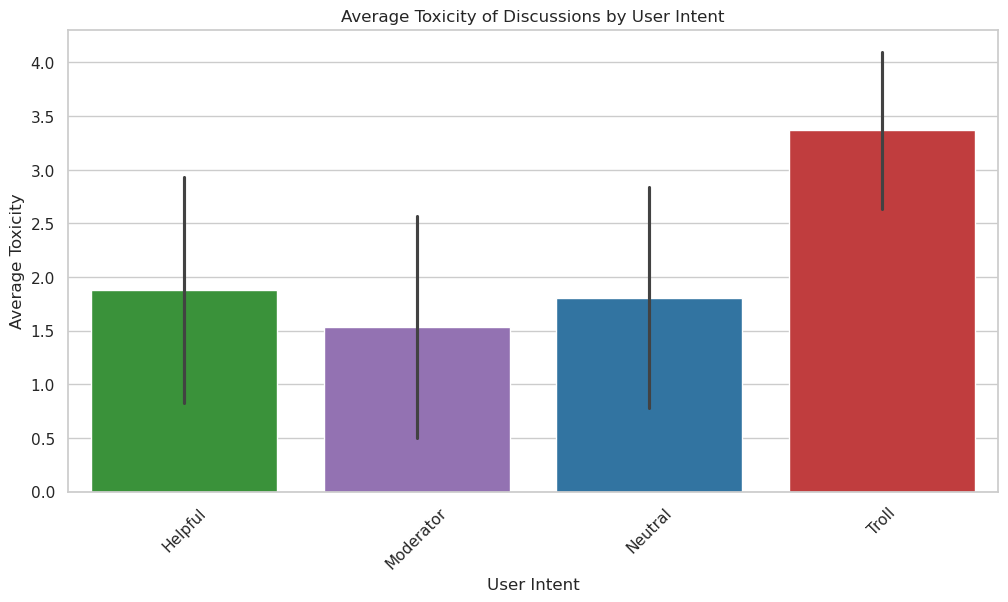

In [15]:
user_intent_order = ["Helpful", "Moderator", "Neutral", "Troll"]
palette = {
    "Helpful": "tab:green",
    "Moderator": "tab:purple",
    "Neutral": "tab:blue",
    "Troll": "tab:red",
}

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x="intent",
    hue="intent",
    y="annotation",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    legend=False,
)

# Customize the plot
plt.title("Average Toxicity of Discussions by User Intent")
plt.xlabel("User Intent")
plt.ylabel("Average Toxicity")
plt.xticks(rotation=45)
plt.show()

### Progression of toxicity

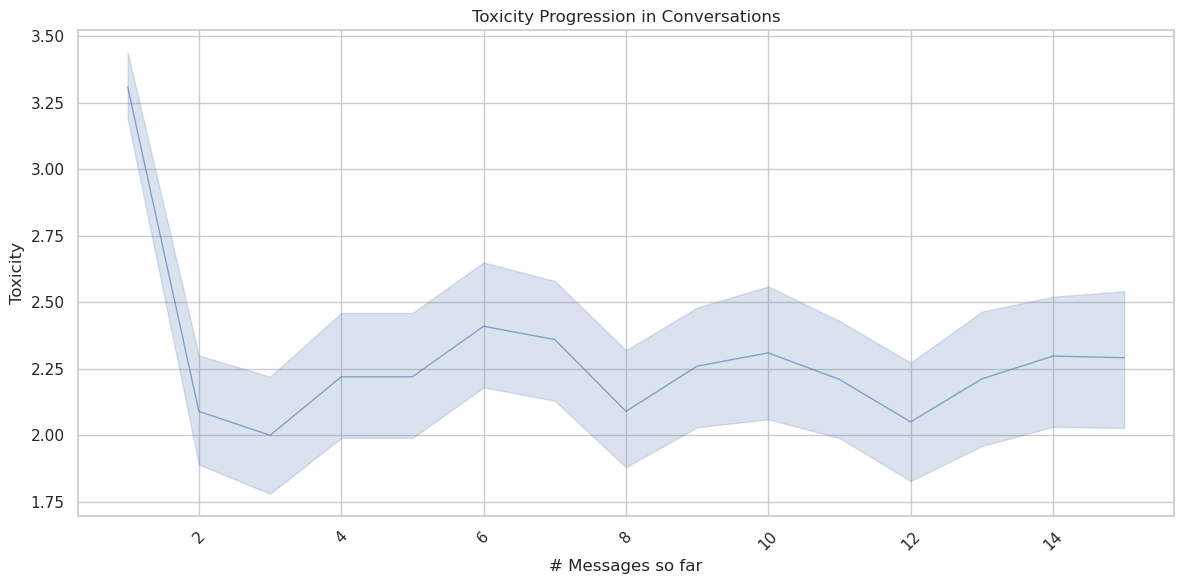

In [16]:
timeseries_df = df.reset_index()
timeseries_df = timeseries_df.drop_duplicates(subset=["conv_id", "user", "message"])

# remove moderator
timeseries_df = timeseries_df[~(timeseries_df.user == "moderator")]

# Filter out conversations with fewer than X comments
conversation_counts = timeseries_df.groupby("conv_id").size()
min_conv_len = 3
valid_conversations = conversation_counts[conversation_counts >= min_conv_len].index
timeseries_df = timeseries_df[timeseries_df["conv_id"].isin(valid_conversations)]

timeseries_df["message_order"] = timeseries_df.groupby("conv_id").cumcount()
timeseries_df.message_order = timeseries_df.message_order + 1  # start from 1

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=timeseries_df, x="message_order", y="annotation", legend=None, lw=1, alpha=0.6
)
plt.title("Toxicity Progression in Conversations")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

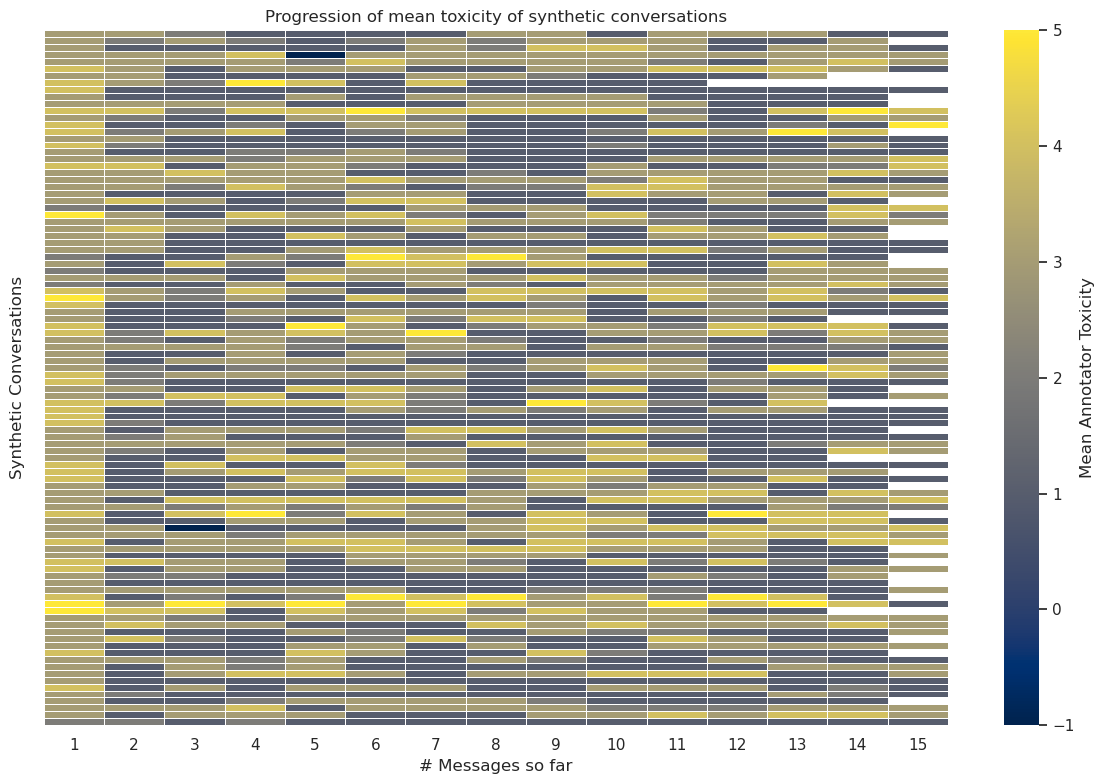

In [17]:
# Calculate the mean toxicity for each message order and conversation
mean_toxicity = (
    timeseries_df.groupby(["conv_id", "message_order"])["annotation"].mean().reset_index()
)

# Pivot the data to create a matrix where rows are conv_id, columns are message_order
heatmap_data = timeseries_df.pivot(
    index="conv_id", columns="message_order", values="annotation"
)

# Create the heatmap plot
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    data=heatmap_data,
    cmap="cividis",
    cbar_kws={"label": "Mean Annotator Toxicity"},
    linewidths=0.5,
)
ax.set(yticklabels=[])
ax.grid(False)

plt.title("Progression of mean toxicity of synthetic conversations")
plt.xlabel("# Messages so far")
plt.ylabel("Synthetic Conversations")
plt.tight_layout()
plt.show()

### Moderator impact

In [18]:
# Create two subsets: one where moderator_exists is True and one where it's False

with_moderator = timeseries_df[timeseries_df["moderator_exists"] == True]
without_moderator = timeseries_df[timeseries_df["moderator_exists"] == False]

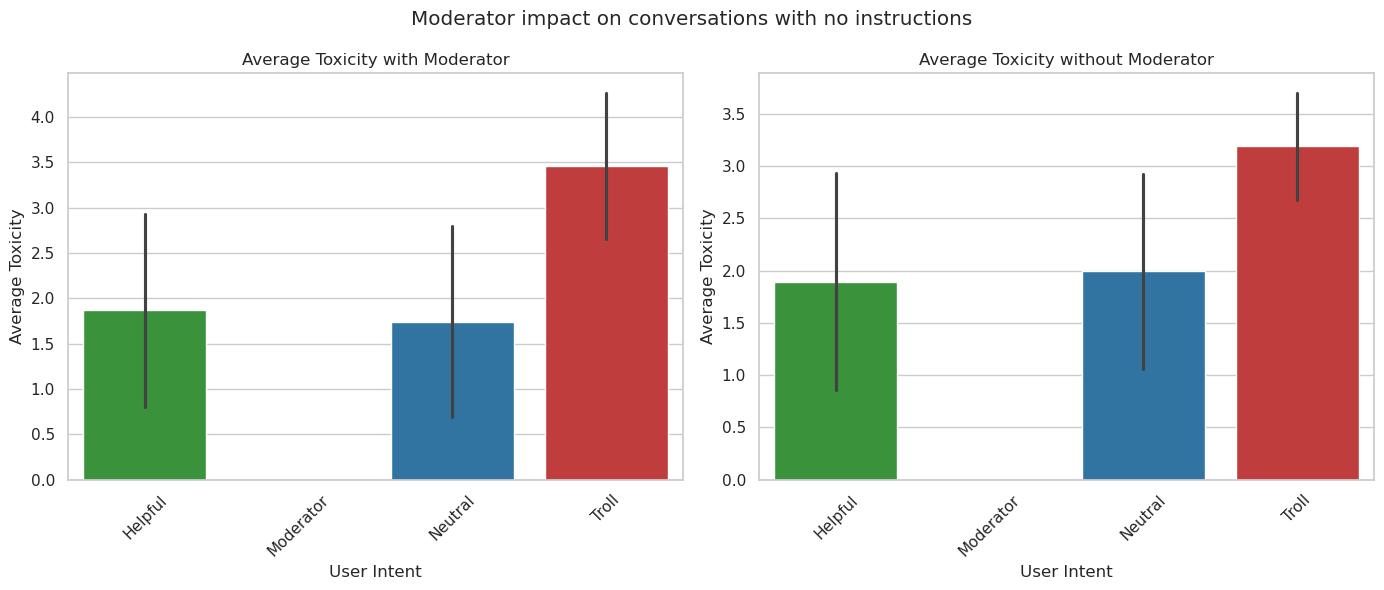

In [20]:
# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for conversations with a moderator
sns.barplot(
    data=with_moderator,
    x="intent",
    hue="intent",
    y="annotation",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    ax=axes[0],  # Assign plot to first subplot (left)
    legend=False,
)
axes[0].set_title("Average Toxicity with Moderator")
axes[0].set_xlabel("User Intent")
axes[0].set_ylabel("Average Toxicity")
axes[0].tick_params(axis="x", rotation=45)

# Plot for conversations without a moderator
sns.barplot(
    data=without_moderator,
    x="intent",
    hue="intent",
    y="annotation",
    order=user_intent_order,
    errorbar="sd",
    palette=palette,
    ax=axes[1],  # Assign plot to second subplot (right)
    legend=False,
)
axes[1].set_title("Average Toxicity without Moderator")
axes[1].set_xlabel("User Intent")
axes[1].set_ylabel("Average Toxicity")
axes[1].tick_params(axis="x", rotation=45)
fig.suptitle("Moderator impact on conversations with no instructions")

# Adjust layout for better display
plt.tight_layout()
plt.show()

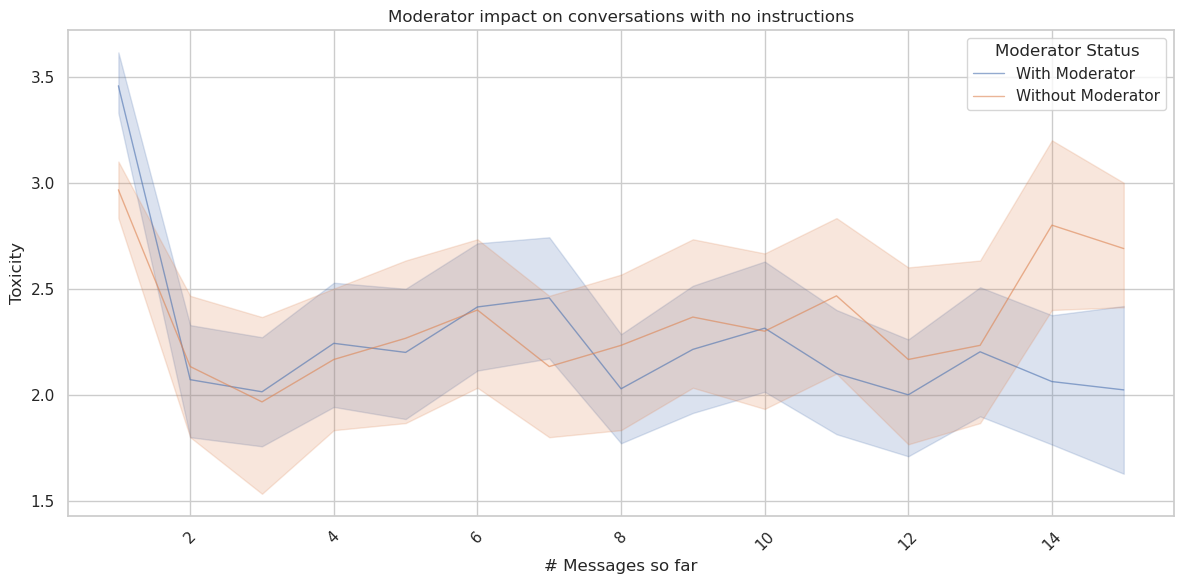

In [22]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot for conversations with a moderator
sns.lineplot(
    data=with_moderator,
    x="message_order",
    y="annotation",
    label="With Moderator",
    lw=1,
    alpha=0.6,
)

# Plot for conversations without a moderator
sns.lineplot(
    data=without_moderator,
    x="message_order",
    y="annotation",
    label="Without Moderator",
    lw=1,
    alpha=0.6,
)

# Customize the plot
plt.title("Moderator impact on conversations with no instructions")
plt.xlabel("# Messages so far")
plt.ylabel("Toxicity")
plt.xticks(rotation=45)
plt.legend(title="Moderator Status")
plt.tight_layout()
plt.show()